# Investigation of Chest X-Ray Images

In [1]:
from __future__ import print_function
import pandas as pd
from keras.preprocessing.image import load_img
from tqdm import tqdm_notebook
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import exposure

%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.ndimage import _ni_support
from scipy.ndimage.filters import convolve1d
from scipy import signal
from IPython.display import display


Using TensorFlow backend.
/home/varun/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Read training CSV file, generate new columns with individual patient, study, and view information from information in the 'Path' column

In [2]:
dir_ = 'CheXpert-v1.0-small'
df = pd.read_csv(dir_+'/'+'train.csv')
a = df['Path'].str.split("/",expand=True)
df['patient']=a[2].str.replace('patient','').astype(int)
df['study'] = a[3].str.replace('study','').astype(int)
df['view'] = a[4].str.split('_', expand=True)[0].str.replace('view','').astype(int)
df

Path     Sex  Age  \
0       CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1       CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2       CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3       CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4       CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   
5       CheXpert-v1.0-small/train/patient00004/study1/...  Female   20   
6       CheXpert-v1.0-small/train/patient00004/study1/...  Female   20   
7       CheXpert-v1.0-small/train/patient00005/study1/...    Male   33   
8       CheXpert-v1.0-small/train/patient00005/study1/...    Male   33   
9       CheXpert-v1.0-small/train/patient00005/study2/...    Male   33   
10      CheXpert-v1.0-small/train/patient00005/study2/...    Male   33   
11      CheXpert-v1.0-small/train/patient00006/study1/...  Female   42   
12      CheXpert-v1.0-small/train/patient00007/study1/...    Male   69   
13      CheXpert-v1.0-small/train/patient00007/study2/...    Male   69   
14      CheXpert-v1.0-small/train/patient00008/study1/...    Male   81   
15      CheXpert-v1.0-small/train/patient00008/study2/...    Male   81   
16      CheXpert-v1.0-small/train/patient00009/study1/...    Male   76   
17      CheXpert-v1.0-small/train/patient00009/study1/...    Male   76   
18      CheXpert-v1.0-small/train/patient00010/study1/...  Female   50   
19      CheXpert-v1.0-small/train/patient00010/study1/...  Female   50   
20      CheXpert-v1.0-small/train/patient00011/study13...  Female   22   
21      CheXpert-v1.0-small/train/patient00011/study13...  Female   22   
22      CheXpert-v1.0-small/train/patient00011/study1/...  Female   19   
23      CheXpert-v1.0-small/train/patient00011/study5/...  Female   19   
24      CheXpert-v1.0-small/train/patient00011/study7/...  Female   19   
25      CheXpert-v1.0-small/train/patient00011/study4/...  Female   19   
26      CheXpert-v1.0-small/train/patient00011/study2/...  Female   19   
27      CheXpert-v1.0-small/train/patient00011/study10...  Female   19   
28      CheXpert-v1.0-small/train/patient00011/study9/...  Female   19   
29      CheXpert-v1.0-small/train/patient00011/study11...  Female   19   
...                                                   ...     ...  ...   
223384  CheXpert-v1.0-small/train/patient64515/study1/...    Male   25   
223385  CheXpert-v1.0-small/train/patient64516/study1/...  Female   75   
223386  CheXpert-v1.0-small/train/patient64517/study1/...    Male   21   
223387  CheXpert-v1.0-small/train/patient64518/study1/...    Male   68   
223388  CheXpert-v1.0-small/train/patient64519/study1/...  Female   33   
223389  CheXpert-v1.0-small/train/patient64520/study1/...  Female   65   
223390  CheXpert-v1.0-small/train/patient64521/study1/...  Female   63   
223391  CheXpert-v1.0-small/train/patient64522/study1/...  Female   21   
223392  CheXpert-v1.0-small/train/patient64523/study1/...  Female   90   
223393  CheXpert-v1.0-small/train/patient64524/study1/...  Female   61   
223394  CheXpert-v1.0-small/train/patient64525/study1/...    Male   87   
223395  CheXpert-v1.0-small/train/patient64526/study1/...    Male   55   
223396  CheXpert-v1.0-small/train/patient64527/study2/...    Male   85   
223397  CheXpert-v1.0-small/train/patient64527/study1/...    Male   85   
223398  CheXpert-v1.0-small/train/patient64528/study1/...    Male   77   
223399  CheXpert-v1.0-small/train/patient64529/study1/...    Male   81   
223400  CheXpert-v1.0-small/train/patient64530/study1/...    Male   65   
223401  CheXpert-v1.0-small/train/patient64531/study1/...  Female   57   
223402  CheXpert-v1.0-small/train/patient64532/study1/...  Female   52   
223403  CheXpert-v1.0-small/train/patient64533/study1/...    Male   75   
223404  CheXpert-v1.0-small/train/patient64533/study2/...    Male   75   
223405  CheXpert-v1.0-small/train/patient64534/study1/...    Male   63   
223406  CheXpert-v1.0-small/train/patient64535/study1/...

## Generate a dummy dataframe to count number of positive labeled diagnosis indications (excluding uncertain ones) for each x-ray:

In [3]:
df_mod = df.replace([-1,0], np.nan)
#df_mod = df.replace(0, np.nan)
df_mod['Count'] = df_mod.iloc[:,5:19].count(axis = 1)
df_mod = df_mod.fillna(0)


## Add this 'Count' to the main data frame:

In [4]:
df['Count'] = df_mod['Count']
df = df.fillna(0)
df

Path     Sex  Age  \
0       CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1       CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2       CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3       CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4       CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   
5       CheXpert-v1.0-small/train/patient00004/study1/...  Female   20   
6       CheXpert-v1.0-small/train/patient00004/study1/...  Female   20   
7       CheXpert-v1.0-small/train/patient00005/study1/...    Male   33   
8       CheXpert-v1.0-small/train/patient00005/study1/...    Male   33   
9       CheXpert-v1.0-small/train/patient00005/study2/...    Male   33   
10      CheXpert-v1.0-small/train/patient00005/study2/...    Male   33   
11      CheXpert-v1.0-small/train/patient00006/study1/...  Female   42   
12      CheXpert-v1.0-small/train/patient00007/study1/...    Male   69   
13      CheXpert-v1.0-small/train/patient00007/study2/...    Male   69   
14      CheXpert-v1.0-small/train/patient00008/study1/...    Male   81   
15      CheXpert-v1.0-small/train/patient00008/study2/...    Male   81   
16      CheXpert-v1.0-small/train/patient00009/study1/...    Male   76   
17      CheXpert-v1.0-small/train/patient00009/study1/...    Male   76   
18      CheXpert-v1.0-small/train/patient00010/study1/...  Female   50   
19      CheXpert-v1.0-small/train/patient00010/study1/...  Female   50   
20      CheXpert-v1.0-small/train/patient00011/study13...  Female   22   
21      CheXpert-v1.0-small/train/patient00011/study13...  Female   22   
22      CheXpert-v1.0-small/train/patient00011/study1/...  Female   19   
23      CheXpert-v1.0-small/train/patient00011/study5/...  Female   19   
24      CheXpert-v1.0-small/train/patient00011/study7/...  Female   19   
25      CheXpert-v1.0-small/train/patient00011/study4/...  Female   19   
26      CheXpert-v1.0-small/train/patient00011/study2/...  Female   19   
27      CheXpert-v1.0-small/train/patient00011/study10...  Female   19   
28      CheXpert-v1.0-small/train/patient00011/study9/...  Female   19   
29      CheXpert-v1.0-small/train/patient00011/study11...  Female   19   
...                                                   ...     ...  ...   
223384  CheXpert-v1.0-small/train/patient64515/study1/...    Male   25   
223385  CheXpert-v1.0-small/train/patient64516/study1/...  Female   75   
223386  CheXpert-v1.0-small/train/patient64517/study1/...    Male   21   
223387  CheXpert-v1.0-small/train/patient64518/study1/...    Male   68   
223388  CheXpert-v1.0-small/train/patient64519/study1/...  Female   33   
223389  CheXpert-v1.0-small/train/patient64520/study1/...  Female   65   
223390  CheXpert-v1.0-small/train/patient64521/study1/...  Female   63   
223391  CheXpert-v1.0-small/train/patient64522/study1/...  Female   21   
223392  CheXpert-v1.0-small/train/patient64523/study1/...  Female   90   
223393  CheXpert-v1.0-small/train/patient64524/study1/...  Female   61   
223394  CheXpert-v1.0-small/train/patient64525/study1/...    Male   87   
223395  CheXpert-v1.0-small/train/patient64526/study1/...    Male   55   
223396  CheXpert-v1.0-small/train/patient64527/study2/...    Male   85   
223397  CheXpert-v1.0-small/train/patient64527/study1/...    Male   85   
223398  CheXpert-v1.0-small/train/patient64528/study1/...    Male   77   
223399  CheXpert-v1.0-small/train/patient64529/study1/...    Male   81   
223400  CheXpert-v1.0-small/train/patient64530/study1/...    Male   65   
223401  CheXpert-v1.0-small/train/patient64531/study1/...  Female   57   
223402  CheXpert-v1.0-small/train/patient64532/study1/...  Female   52   
223403  CheXpert-v1.0-small/train/patient64533/study1/...    Male   75   
223404  CheXpert-v1.0-small/train/patient64533/study2/...    Male   75   
223405  CheXpert-v1.0-small/train/patient64534/study1/...    Male   63   
223406  CheXpert-v1.0-small/train/patient64535/study1/...

In [5]:
print('Total Number of Patients:', len(df.groupby('patient')))
print('Total Number of X-Rays', len(df))
print('Total Number of Frontal X Rays: ', df.groupby('Frontal/Lateral').size()[0])
print('Total Number of Lateral X Rays: ', df.groupby('Frontal/Lateral').size()[1])

Total Number of Patients: 64540
Total Number of X-Rays 223414
Total Number of Frontal X Rays:  191027
Total Number of Lateral X Rays:  32387


## Some patients have more than one x-ray image, calculate the distribution 

In [6]:
grouped = df.groupby(['patient']).size().reset_index()
grouped.columns = ['patient', 'num_xrays']
grouped2 = grouped.groupby('num_xrays').count().reset_index()
grouped2.columns = ['Total Number of X Rays', 'Number of Patients']
grouped2

Total Number of X Rays  Number of Patients
0                        1               22581
1                        2               17547
2                        3                6965
3                        4                4685
4                        5                2910
5                        6                2154
6                        7                1414
7                        8                1168
8                        9                 909
9                       10                 685
10                      11                 555
11                      12                 432
12                      13                 351
13                      14                 301
14                      15                 245
15                      16                 198
16                      17                 152
17                      18                 176
18                      19                 125
19                      20                 130
20                      21                 101
21                      22                  59
22                      23                  83
23                      24                  60
24                      25                  66
25                      26                  52
26                      27                  39
27                      28                  29
28                      29                  28
29                      30                  25
..                     ...                 ...
49                      50                   2
50                      51                   7
51                      52                   2
52                      53                   3
53                      54                   3
54                      55                   5
55                      56                   3
56                      57                   3
57                      58                   1
58                      59                   3
59                      60                   3
60                      62                   2
61                      64                   1
62                      65                   4
63                      66                   1
64                      67                   1
65                      68                   1
66                      71                   1
67                      72                   3
68                      73                   1
69                      74                   1
70                      75                   1
71                      76                   4
72                      77                   1
73                      79                   2
74                      80                   1
75                      85                   1
76                      86                   1
77                      89                   1
78                      92                   2

[79 rows x 2 columns]

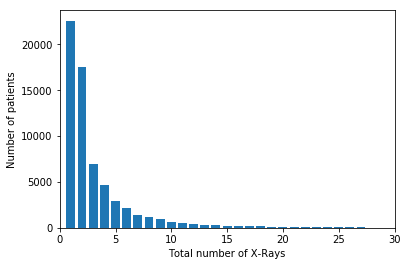

In [7]:
plt.bar(grouped2['Total Number of X Rays'], grouped2['Number of Patients'])
plt.xlim(0,30)
plt.xlabel('Total number of X-Rays')
plt.ylabel('Number of patients')
plt.show()

## Count the x-rays with a certain number of positive diagnosis labels out of 14 (doesn't include uncertain labels)

In [8]:
grouped = df.groupby('Count').size().reset_index()
grouped.columns = ['Number of labels', 'Count']
grouped['Percentage'] = (100*grouped['Count']/grouped['Count'].sum()).round(3)
grouped

Number of labels  Count  Percentage
0                 0  11141       4.987
1                 1  52778      23.623
2                 2  66104      29.588
3                 3  54151      24.238
4                 4  29550      13.227
5                 5   8333       3.730
6                 6   1224       0.548
7                 7    123       0.055
8                 8     10       0.004

## For each diagnosis label, count the uncertain, negative, and positive labels

In [9]:
for cols in df.columns[5:19]:
    grouped = df.groupby(cols).size().reset_index()
    grouped.columns = [cols, 'Count']
    grouped.loc[grouped[cols] == -1, cols] = 'Uncertain'
    grouped.loc[grouped[cols] == 0, cols] = 'Negative'
    grouped.loc[grouped[cols] == 1,cols] = 'Positive'
    grouped['Percentage'] = (100*grouped['Count']/grouped['Count'].sum()).round(3)
    display(grouped)

No Finding   Count  Percentage
0   Negative  201033      89.982
1   Positive   22381      10.018

Enlarged Cardiomediastinum   Count  Percentage
0                  Uncertain   12403       5.552
1                   Negative  200213      89.615
2                   Positive   10798       4.833

Cardiomegaly   Count  Percentage
0    Uncertain    8087       3.620
1     Negative  188327      84.295
2     Positive   27000      12.085

Lung Opacity   Count  Percentage
0    Uncertain    5598       2.506
1     Negative  112235      50.236
2     Positive  105581      47.258

Lung Lesion   Count  Percentage
0   Uncertain    1488       0.666
1    Negative  212740      95.222
2    Positive    9186       4.112

Edema   Count  Percentage
0  Uncertain   12984       5.812
1   Negative  158184      70.803
2   Positive   52246      23.385

Consolidation   Count  Percentage
0     Uncertain   27742      12.417
1      Negative  180889      80.966
2      Positive   14783       6.617

Pneumonia   Count  Percentage
0  Uncertain   18770       8.401
1   Negative  198605      88.896
2   Positive    6039       2.703

Atelectasis   Count  Percentage
0   Uncertain   33739      15.102
1    Negative  156299      69.959
2    Positive   33376      14.939

Pneumothorax   Count  Percentage
0    Uncertain    3145       1.408
1     Negative  200821      89.887
2     Positive   19448       8.705

Pleural Effusion   Count  Percentage
0        Uncertain   11628       5.205
1         Negative  125599      56.218
2         Positive   86187      38.577

Pleural Other   Count  Percentage
0     Uncertain    2653       1.187
1      Negative  217238      97.236
2      Positive    3523       1.577

Fracture   Count  Percentage
0  Uncertain     642       0.287
1   Negative  213732      95.666
2   Positive    9040       4.046

Support Devices   Count  Percentage
0       Uncertain    1079       0.483
1        Negative  106334      47.595
2        Positive  116001      51.922

## Interactively display some images based on chosen criteria

In [10]:
def display_images(sex, image_orientation, image_type, no_finding, enlg_cardio, cardiomegaly, lung_opacity, \
                   lung_lesion, edema, consolidation, pneumonia, atelectasis, pneumothorax, pleural_effusion, \
                   pleural_other, fracture, support_devices):
    sample_df = df_mod[(df_mod['Sex'] == sex) & (df_mod['Frontal/Lateral'] == image_orientation) & \
                       (df_mod['AP/PA'] == image_type) & (df_mod['No Finding'] == int(no_finding)) & \
                       (df_mod['Enlarged Cardiomediastinum'] == int(enlg_cardio)) & \
                       (df_mod['Cardiomegaly'] == int(cardiomegaly)) & \
                       (df_mod['Lung Opacity'] == int(lung_opacity)) & \
                       (df_mod['Lung Lesion'] == int(lung_lesion)) & (df_mod['Edema'] == int(edema)) & \
                       (df_mod['Consolidation'] == int(consolidation)) & \
                       (df_mod['Pneumonia'] == int(pneumonia)) & (df_mod['Atelectasis'] == int(atelectasis)) & \
                       (df_mod['Pneumothorax'] == int(pneumothorax)) & \
                       (df_mod['Pleural Effusion'] == int(pleural_effusion)) & \
                       (df_mod['Pleural Other'] == int(pleural_other)) & (df_mod['Fracture'] == int(fracture)) & \
                       (df_mod['Support Devices'] == int(support_devices))].sample(20)
    images = [resize(np.array(load_img("{}".format(path))), (320,320), anti_aliasing = True) for path in tqdm_notebook(sample_df['Path'])]
    titles = np.array(sample_df.iloc[:,[2,4,19,20,21]])
    fig = plt.figure(figsize=(20, 60))  

    for i in range(len(images)):
        sub = fig.add_subplot(7, 5, i + 1)
        sub.set_title('Patient {0} \n Age: {1} \n Study Number: {2} \n View Number: {3}'\
                      .format(titles[i][2], titles[i][0], titles[i][3], titles[i][4]), fontsize = 15)
        sub.imshow(images[i])

def display_images_small(df):
    images = [resize(np.array(load_img("{}".format(path))), (320,320), anti_aliasing = True) for path in tqdm_notebook(df['Path'])]
    titles = np.array(df.iloc[:,[2,4,19,20,21]])
    fig = plt.figure(figsize=(20, 80))  
    for i in range(len(images)):
        sub = fig.add_subplot(12, 5, i + 1)
        sub.set_title('Patient {0} \n Age: {1} \n Study Number: {2} \n View Number: {3}'.format(titles[i][2], titles[i][0], titles[i][3], titles[i][4]), fontsize = 15)
        sub.imshow(images[i])

In [11]:
interact(display_images, sex = ['Male', 'Female'], image_orientation = ['Frontal', 'Lateral'], \
         image_type = ['AP', 'PA', 0], no_finding=True, enlg_cardio = False, cardiomegaly = False, \
         lung_opacity = False, lung_lesion = False, edema = False, consolidation = False, \
         pneumonia = False, atelectasis = False, pneumothorax = False, pleural_effusion = False, \
         pleural_other = False, fracture = False, support_devices = False)


interactive(children=(Dropdown(description='sex', options=('Male', 'Female'), value='Male'), Dropdown(descript…

<function __main__.display_images(sex, image_orientation, image_type, no_finding, enlg_cardio, cardiomegaly, lung_opacity, lung_lesion, edema, consolidation, pneumonia, atelectasis, pneumothorax, pleural_effusion, pleural_other, fracture, support_devices)>

## Some more example images, each row are images from a certain diagnosis (single diagnosis cases and frontal images only)

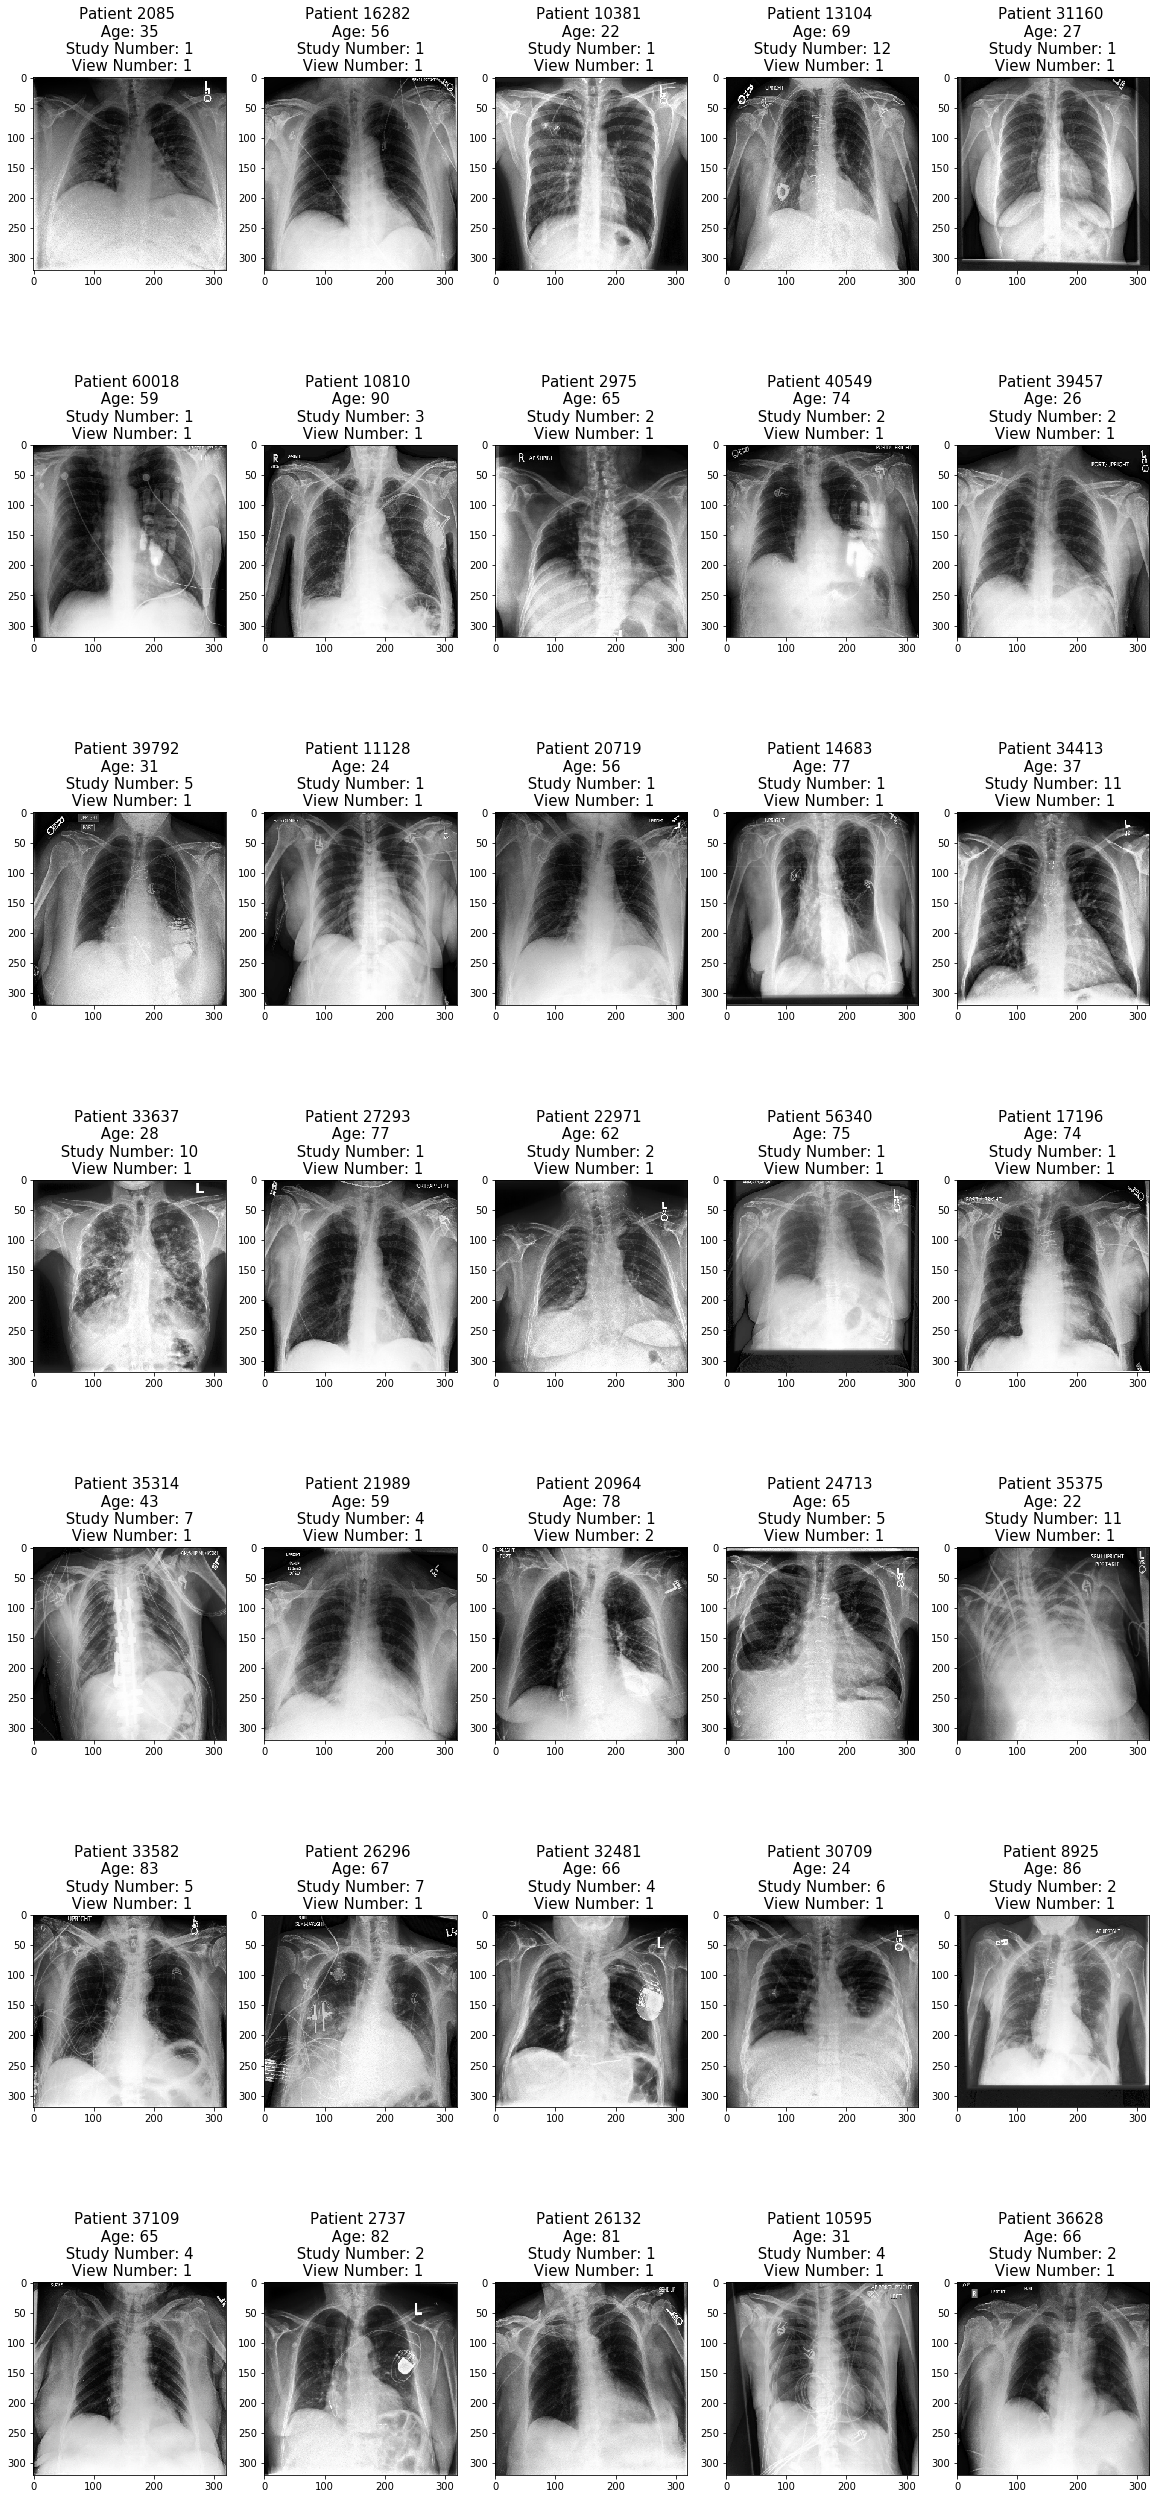

In [12]:
df_nofinding = df[(df['No Finding']==1) & (df['Count']==1) & (df['Frontal/Lateral']=='Frontal')].sample(5)
df_atelectasis = df[(df['Atelectasis']==1) & (df['Count']==1) & (df['Frontal/Lateral']=='Frontal')].sample(5)
df_cardiomegaly = df[(df['Cardiomegaly']==1) & (df['Count']==1) & (df['Frontal/Lateral']=='Frontal')].sample(5)
df_consolidation = df[(df['Consolidation']==1) & (df['Count']==1) & (df['Frontal/Lateral']=='Frontal')].sample(5)
df_edema = df[(df['Edema']==1) & (df['Count']==1) & (df['Frontal/Lateral']=='Frontal')].sample(5)
df_pleuraleffusion = df[(df['Pleural Effusion']==1) & (df['Count']==1) & (df['Frontal/Lateral']=='Frontal')].sample(5)
df_supportdevices = df[(df['Support Devices']==1) & (df['Count']==1) & (df['Frontal/Lateral']=='Frontal')].sample(5)
df_list = [df_nofinding, df_atelectasis, df_cardiomegaly, df_consolidation, df_edema, df_pleuraleffusion, df_supportdevices]
df_samples = pd.concat(df_list)
display_images_small(df_samples)

## Display some problematic images

In [13]:
problem_df = df[(df['AP/PA'] != 'AP') & (df['AP/PA'] != 'PA') & (df['AP/PA'] != 0)]
problem_df

Path     Sex  Age  \
32625   CheXpert-v1.0-small/train/patient07958/study5/...  Female   64   
33939   CheXpert-v1.0-small/train/patient08287/study5/...  Female   55   
36738   CheXpert-v1.0-small/train/patient09010/study1/...  Female   76   
50958   CheXpert-v1.0-small/train/patient12419/study1/...    Male   57   
65091   CheXpert-v1.0-small/train/patient15664/study1/...    Male   38   
74121   CheXpert-v1.0-small/train/patient17783/study1/...    Male   62   
81291   CheXpert-v1.0-small/train/patient19531/study1/...    Male   72   
104594  CheXpert-v1.0-small/train/patient25114/study3/...    Male   79   
104743  CheXpert-v1.0-small/train/patient25145/study2/...    Male   83   
105621  CheXpert-v1.0-small/train/patient25359/study12...    Male   55   
108174  CheXpert-v1.0-small/train/patient25979/study8/...    Male   28   
116963  CheXpert-v1.0-small/train/patient28011/study2/...  Female   23   
120803  CheXpert-v1.0-small/train/patient28939/study1/...    Male   69   
125049  CheXpert-v1.0-small/train/patient29942/study3/...    Male   80   
126163  CheXpert-v1.0-small/train/patient30230/study1/...    Male   68   
130315  CheXpert-v1.0-small/train/patient31206/study1/...    Male   29   
201068  CheXpert-v1.0-small/train/patient50022/study1/...  Female   44   

       Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  \
32625          Frontal    LL         0.0                         0.0   
33939          Frontal    LL         0.0                         0.0   
36738          Frontal    LL         0.0                         0.0   
50958          Frontal    LL         0.0                         0.0   
65091          Frontal    LL         1.0                         0.0   
74121          Frontal    LL         0.0                         0.0   
81291          Frontal    LL         0.0                         0.0   
104594         Frontal    LL         0.0                         1.0   
104743         Frontal    LL         0.0                         0.0   
105621         Frontal    LL         0.0                         0.0   
108174         Frontal    LL         0.0                         0.0   
116963         Frontal    LL         1.0                         0.0   
120803         Frontal    LL         1.0                         0.0   
125049         Frontal    LL         0.0                         0.0   
126163         Frontal    LL         0.0                         0.0   
130315         Frontal    LL         1.0                         0.0   
201068         Frontal    RL         0.0                         0.0   

        Cardiomegaly  Lung Opacity  Lung Lesion  ...  Atelectasis  \
32625            0.0           0.0          0.0  ...          0.0   
33939            0.0           0.0          0.0  ...          0.0   
36738            0.0           1.0          0.0  ...          1.0   
50958           -1.0           0.0          0.0  ...          0.0   
65091            0.0           0.0          0.0  ...          0.0   
74121            0.0           1.0          0.0  ...          0.0   
81291           -1.0           0.0          0.0  ...          0.0   
104594           1.0           0.0          0.0  ...          0.0   
104743           0.0           0.0          0.0  ...          0.0   
105621           0.0           1.0          0.0  ...         -1.0   
108174           0.0           0.0          0.0  ...          1.0   
116963           0.0           0.0          0.0  ...          0.0   
120803           0.0           0.0          0.0  ...          0.0   
125049          -1.0           1.0          0.0  ...         -1.0   
126163           0.0           0.0          0.0  ...          0.0   
130315           0.0           0.0          0.0  ...          0.0   
201068           0.0           0.0          0.0  ...          0.0   

        Pneumothorax  Pleural Effusion  Pleural Other  Fracture  \
32625            0.0               1.0            0.0       0.0   
33939            0.0               1.0        

## Images with AP/PA label not equal to AP or PA seem to have issues, only 17 such cases. Some of these are seen to be noisy/corrupt images

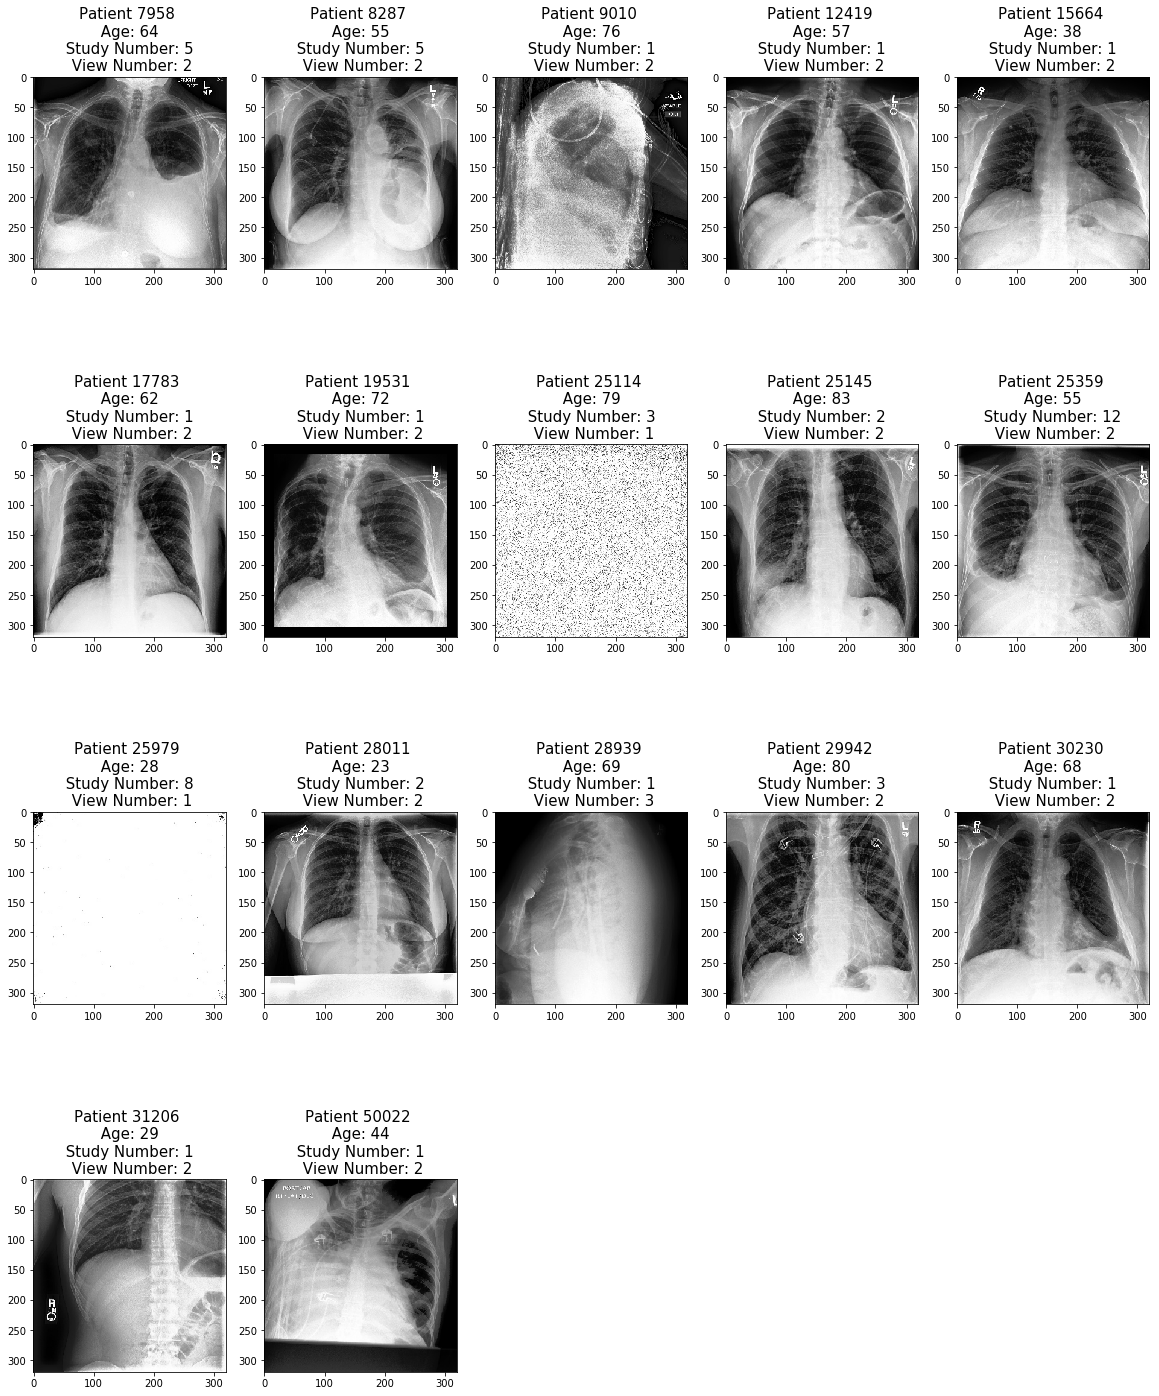

In [14]:
display_images_small(problem_df)

In [15]:
problem_df = df[df['patient']==58483]
problem_df

Path   Sex  Age  \
215441  CheXpert-v1.0-small/train/patient58483/study3/...  Male   63   
215442  CheXpert-v1.0-small/train/patient58483/study6/...  Male   63   
215443  CheXpert-v1.0-small/train/patient58483/study4/...  Male   63   
215444  CheXpert-v1.0-small/train/patient58483/study2/...  Male   63   
215445  CheXpert-v1.0-small/train/patient58483/study1/...  Male   63   
215446  CheXpert-v1.0-small/train/patient58483/study7/...  Male   63   
215447  CheXpert-v1.0-small/train/patient58483/study5/...  Male   63   

       Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  \
215441         Frontal    AP         0.0                         0.0   
215442         Frontal    AP         0.0                         0.0   
215443         Frontal    AP         0.0                         0.0   
215444         Frontal    AP         0.0                         0.0   
215445         Frontal    AP         0.0                         0.0   
215446         Frontal    AP         1.0                         0.0   
215447         Frontal    AP         0.0                         0.0   

        Cardiomegaly  Lung Opacity  Lung Lesion  ...  Atelectasis  \
215441           0.0           1.0          0.0  ...          0.0   
215442           0.0           0.0          0.0  ...          0.0   
215443           0.0           1.0          0.0  ...         -1.0   
215444           0.0           1.0          0.0  ...         -1.0   
215445           0.0           1.0          0.0  ...         -1.0   
215446           0.0           0.0          0.0  ...          0.0   
215447           0.0           0.0          0.0  ...          0.0   

        Pneumothorax  Pleural Effusion  Pleural Other  Fracture  \
215441           1.0               1.0            0.0       0.0   
215442           0.0               0.0            0.0       0.0   
215443           1.0               0.0            0.0       0.0   
215444           1.0               0.0            0.0       0.0   
215445           1.0               0.0            0.0       0.0   
215446           0.0               0.0            0.0       0.0   
215447           0.0               0.0            0.0       0.0   

        Support Devices  patient  study  view  Count  
215441              0.0    58483      3     1      3  
215442              1.0    58483      6     1      1  
215443              0.0    58483      4     1      3  
215444              0.0    58483      2     1      2  
215445              1.0    58483      1     1      3  
215446              0.0    58483      7     1      1  
215447              1.0    58483      5     1      1  

[7 rows x 23 columns]

## Bottom left image is corrupt

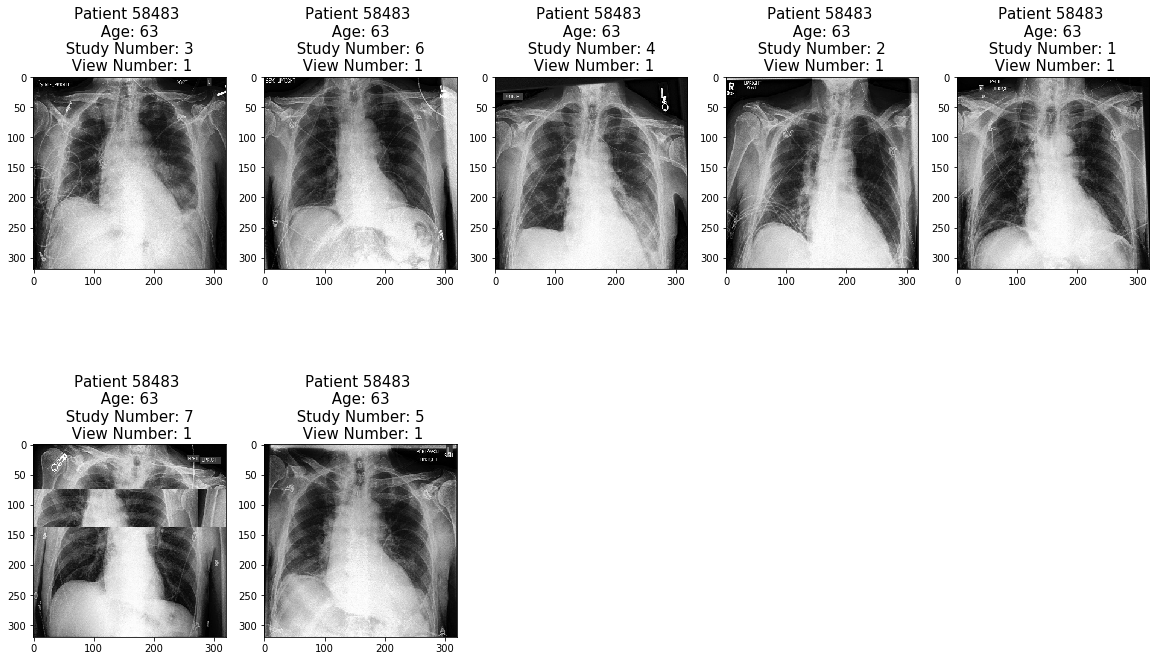

In [16]:
display_images_small(problem_df)

In [17]:
problem_df = df[df['patient']==27543]
problem_df

Path   Sex  Age  \
114791  CheXpert-v1.0-small/train/patient27543/study1/...  Male   20   
114792  CheXpert-v1.0-small/train/patient27543/study2/...  Male   20   
114793  CheXpert-v1.0-small/train/patient27543/study23...  Male   20   
114794  CheXpert-v1.0-small/train/patient27543/study3/...  Male   20   
114795  CheXpert-v1.0-small/train/patient27543/study15...  Male   20   
114796  CheXpert-v1.0-small/train/patient27543/study34...  Male   20   
114797  CheXpert-v1.0-small/train/patient27543/study6/...  Male   20   
114798  CheXpert-v1.0-small/train/patient27543/study37...  Male   20   
114799  CheXpert-v1.0-small/train/patient27543/study24...  Male   20   
114800  CheXpert-v1.0-small/train/patient27543/study21...  Male   20   
114801  CheXpert-v1.0-small/train/patient27543/study49...  Male   27   
114802  CheXpert-v1.0-small/train/patient27543/study11...  Male   20   
114803  CheXpert-v1.0-small/train/patient27543/study27...  Male   20   
114804  CheXpert-v1.0-small/train/patient27543/study30...  Male   20   
114805  CheXpert-v1.0-small/train/patient27543/study9/...  Male   20   
114806  CheXpert-v1.0-small/train/patient27543/study41...  Male   20   
114807  CheXpert-v1.0-small/train/patient27543/study28...  Male   20   
114808  CheXpert-v1.0-small/train/patient27543/study33...  Male   20   
114809  CheXpert-v1.0-small/train/patient27543/study46...  Male   21   
114810  CheXpert-v1.0-small/train/patient27543/study14...  Male   20   
114811  CheXpert-v1.0-small/train/patient27543/study10...  Male   20   
114812  CheXpert-v1.0-small/train/patient27543/study12...  Male   20   
114813  CheXpert-v1.0-small/train/patient27543/study47...  Male   27   
114814  CheXpert-v1.0-small/train/patient27543/study43...  Male   20   
114815  CheXpert-v1.0-small/train/patient27543/study13...  Male   20   
114816  CheXpert-v1.0-small/train/patient27543/study17...  Male   20   
114817  CheXpert-v1.0-small/train/patient27543/study36...  Male   20   
114818  CheXpert-v1.0-small/train/patient27543/study38...  Male   20   
114819  CheXpert-v1.0-small/train/patient27543/study51...  Male   27   
114820  CheXpert-v1.0-small/train/patient27543/study26...  Male   20   
114821  CheXpert-v1.0-small/train/patient27543/study45...  Male   21   
114822  CheXpert-v1.0-small/train/patient27543/study29...  Male   20   
114823  CheXpert-v1.0-small/train/patient27543/study52...  Male   27   
114824  CheXpert-v1.0-small/train/patient27543/study35...  Male   20   
114825  CheXpert-v1.0-small/train/patient27543/study4/...  Male   20   
114826  CheXpert-v1.0-small/train/patient27543/study44...  Male   21   
114827  CheXpert-v1.0-small/train/patient27543/study31...  Male   20   
114828  CheXpert-v1.0-small/train/patient27543/study25...  Male   20   
114829  CheXpert-v1.0-small/train/patient27543/study8/...  Male   20   
114830  CheXpert-v1.0-small/train/patient27543/study42...  Male   20   
114831  CheXpert-v1.0-small/train/patient27543/study16...  Male   20   
114832  CheXpert-v1.0-small/train/patient27543/study53...  Male   31   
114833  CheXpert-v1.0-small/train/patient27543/study39...  Male   20   
114834  CheXpert-v1.0-small/train/patient27543/study48...  Male   27   
114835  CheXpert-v1.0-small/train/patient27543/study7/...  Male   20   
114836  CheXpert-v1.0-small/train/patient27543/study22...  Male   20   
114837  CheXpert-v1.0-small/train/patient27543/study18...  Male   20   
114838  CheXpert-v1.0-small/train/patient27543/study40...  Male   20   
114839  CheXpert-v1.0-small/train/patient27543/study20...  Male   20   
114840  CheXpert-v1.0-small/train/patient27543/study5/...  Male   20   
114841  CheXpert-v1.0-small/train/patient27543/study32...  Male   20   
114842  CheXpert-v1.0-small/train/patient27543/study50...  Male   27   
114843  CheXpert-v1.0-small/train/patient27543/study19...  Male   20   

       Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  \
114791         Frontal    AP         0.0                         0.0   
114792         Front

## Images below seem to be outliers, possibly from a disabled patient with deformities

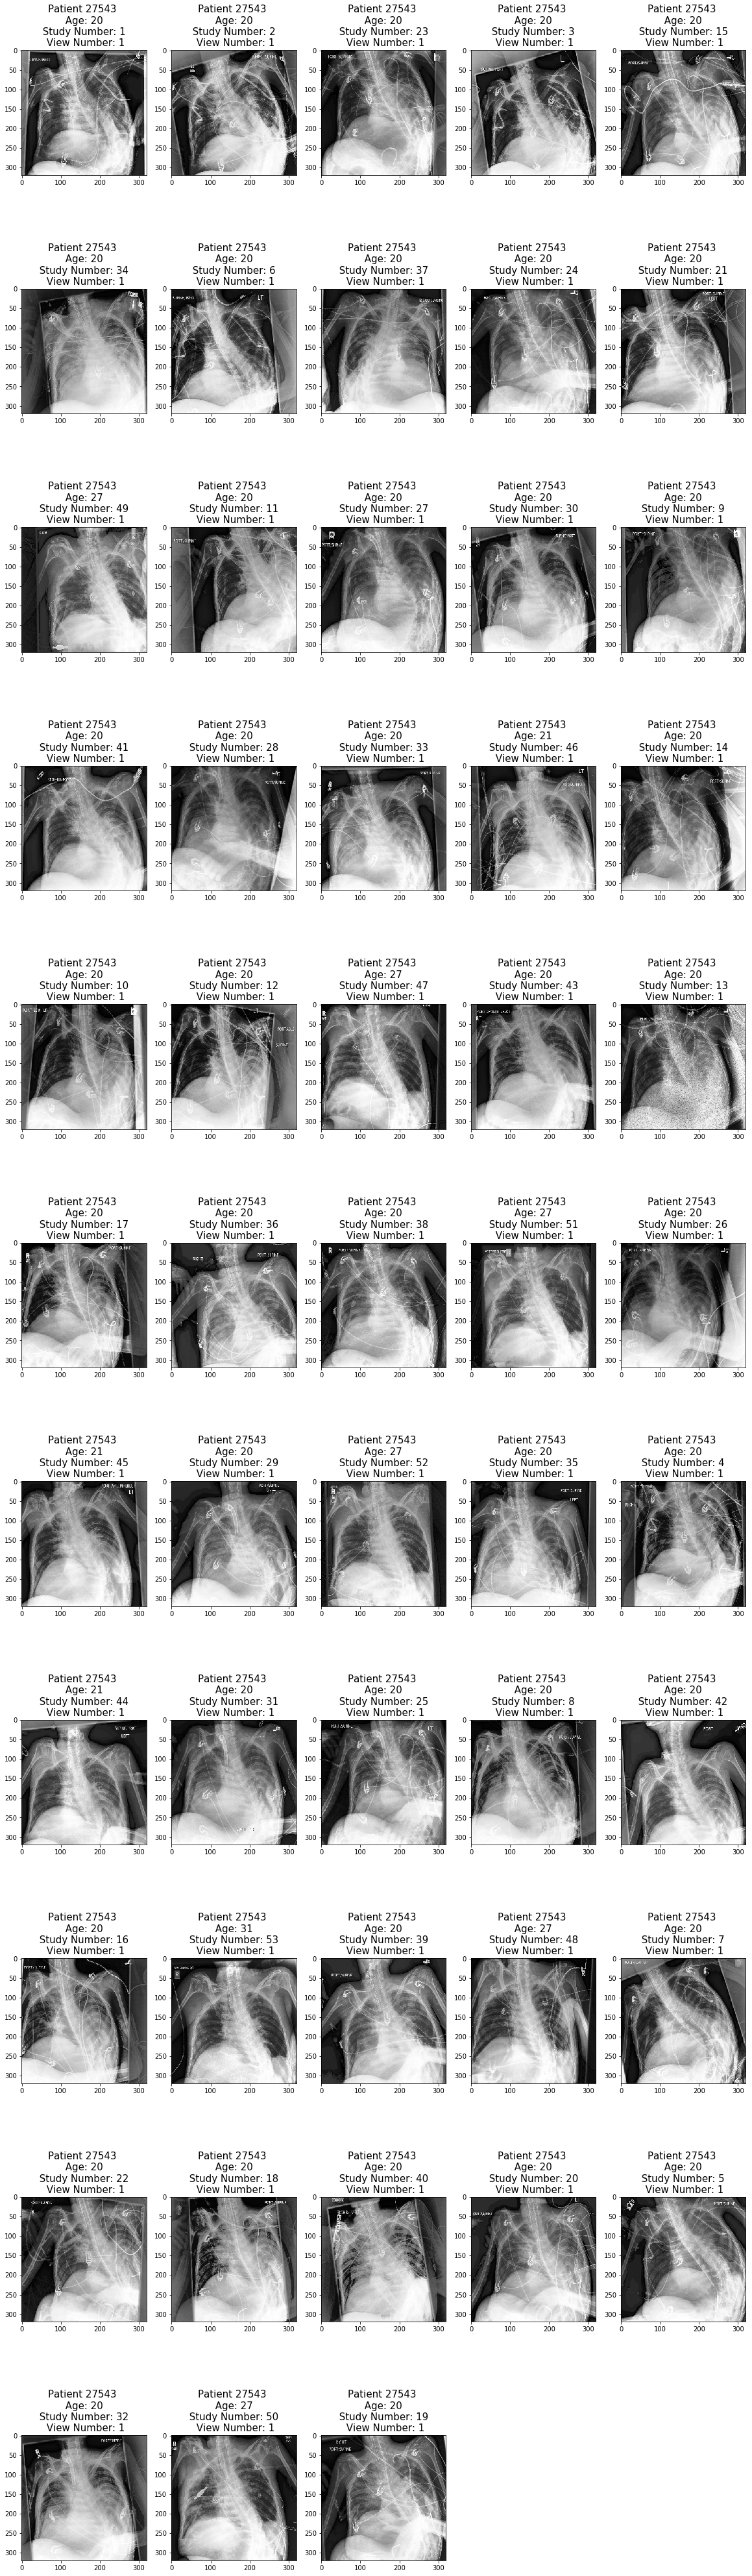

In [18]:
display_images_small(problem_df)